In [1]:
!ls

catboost_info               gold_recovery_train_new.csv
gold_recovery_full_new.csv  ntb.ipynb
gold_recovery_test_new.csv


# 1. Подготовьте данные
## 1.1. Откройте файлы и изучите их.

In [2]:
import pandas as pd 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt 
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,7)

import catboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.metrics import make_scorer 
from sklearn.preprocessing import StandardScaler


In [3]:
train_df = pd.read_csv('gold_recovery_train_new.csv')
test_df = pd.read_csv('gold_recovery_test_new.csv')
full_df = pd.read_csv('gold_recovery_full_new.csv')

In [4]:
dfs = [train_df, test_df, full_df]

## 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [5]:
train_df['rougher.output.recovery'] #то что перепроверям 

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [7]:
#display(train_df.iloc[:, 30:65].head())
display(train_df.iloc[:, 30:65].columns)

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floa

сначала нужно посчитть это: 

- C — доля золота в концентрате после флотации/очистки; (+) (rougher.output.feed_au_share)
- F — доля золота в сырье/концентрате до флотации/очистки; (+) (rougher.input.feed_au_share)
- T — доля золота в отвальных хвостах после флотации/очистки.

In [8]:
 #rougher.output.concentrate_au - rougher.input.feed_au - rougher.output.tail_au
train_df[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]

C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

train_df['recovery_test'] = (C*(F-T))/(F*(C-T))*100


In [9]:
#появились наны из-за нулей в rougher.output.concentrate_so
train_df[train_df['recovery_test'].isnull()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery_test


In [10]:
#посмотрим что без нанов 
print(mean_absolute_error(train_df.dropna(subset=['recovery_test'])['rougher.output.recovery'], 
                            train_df.dropna(subset=['recovery_test'])['recovery_test']))

9.73512347450521e-15


## 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [11]:
test_df.isnull().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

In [12]:
print('columns in train', len(train_df.columns))
print('columns in test', len(test_df.columns))

print(len(set(train_df.columns).difference(set(test_df.columns))))
train_test_dif_cols = set(train_df.columns).difference(set(test_df.columns))

columns in train 88
columns in test 53
35


In [13]:
from pprint import pprint 
pprint(train_test_dif_cols)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery_test',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 

## 1.4. Проведите предобработку данных.

Что можно сделать в предобработке: 

1. удалить из train колонки, которые недоступны в test (позже)
2. Удалить пропуски, если их немного 
3. сбросить дубликаты 

In [14]:
cols = test_df.columns

for df in dfs: 
    #проверка на дубликаты 
    print(len(df.columns))
    #тут пока непонятно, стоит ли до EDA удалять колонки 
    #df = df[cols]
    print(len(df.columns))
    print(df.shape)
    print(df.duplicated().sum())
    print(df.isnull().sum().sort_values(ascending=False))
    

88
88
(14149, 88)
0
secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
final.output.tail_pb                                   100
rougher.input.feed_pb                                  100
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol      

# 2. Проанализируйте данные


## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы. (на обучающей выборке)

In [15]:
#словарь столбцов с инпутом и аутпутом в этапах, чтобы проще было ковыряться в этом безобразии
l_cols = {}

for l in ['rougher', 'primary_cleaner',
           'secondary_cleaner', 'final']:
    
    l_cols[l] = {}
    l_cols[l]['input'] = []
    l_cols[l]['output'] = []

    print(l)
    
    for col in full_df.columns:

        if l == col.split('.')[0] and col.split('.')[1] == 'input':
            l_cols[l]['input'].append(col)
        elif l == col.split('.')[0] and col.split('.')[1] == 'output':
            l_cols[l]['output'].append(col)
        else:
            continue

rougher
primary_cleaner
secondary_cleaner
final


### rougher

In [16]:
l_cols['rougher']['output']

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au']

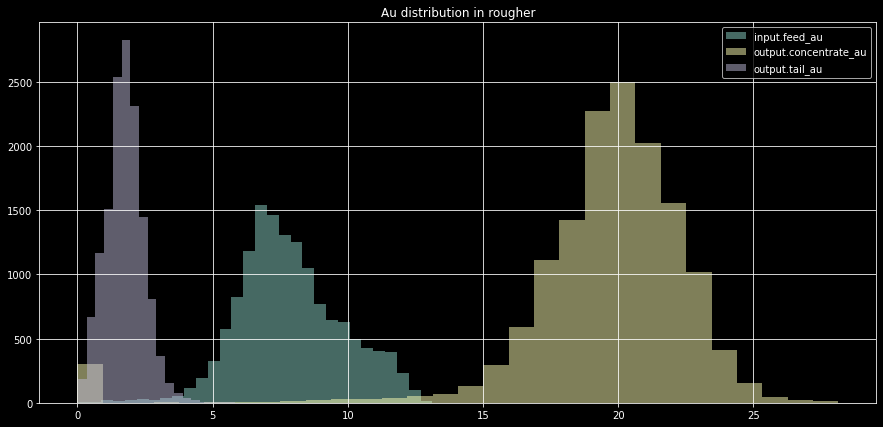

In [17]:
train_df['rougher.input.feed_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Au distribution in rougher')
plt.legend(['input.feed_au', 'output.concentrate_au', 'output.tail_au'])
plt.show()

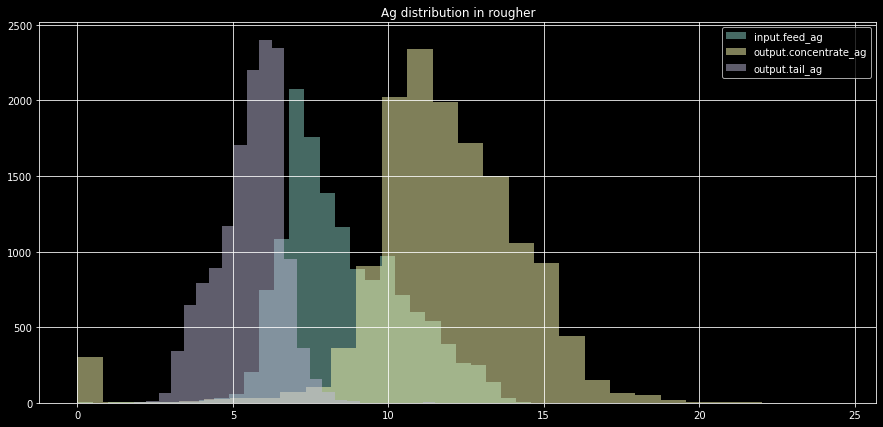

In [18]:
train_df['rougher.input.feed_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_ag'].hist(alpha = 0.5, bins =30)
plt.title('Ag distribution in rougher')
plt.legend(['input.feed_ag', 'output.concentrate_ag', 'output.tail_ag'])
plt.show()

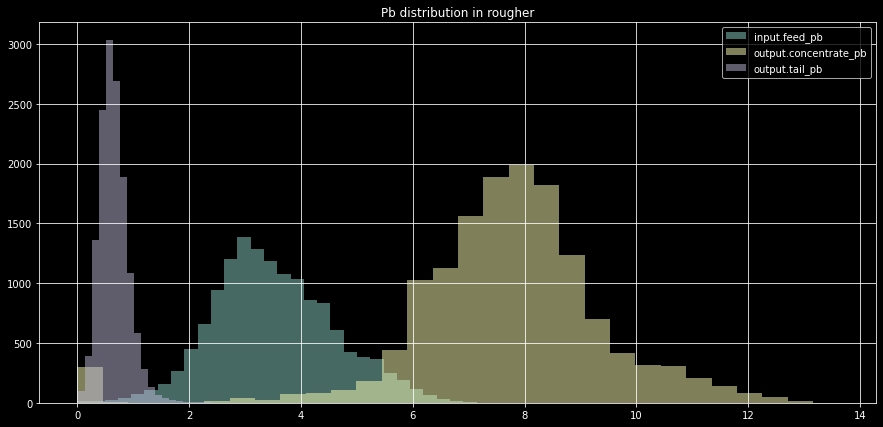

In [19]:
train_df['rougher.input.feed_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_pb'].hist(alpha = 0.5, bins =30)
plt.title('Pb distribution in rougher')
plt.legend(['input.feed_pb', 'output.concentrate_pb', 'output.tail_pb'])
plt.show()

Получается, что даже первый этап грубой очистки уже справляется со своей работой. 

Особенно хорошо он справляется с золотом и свинцом, хуже справляется с серебром при этом. 

### primary_cleaner

In [20]:
l_cols['primary_cleaner']

{'input': ['primary_cleaner.input.sulfate',
  'primary_cleaner.input.depressant',
  'primary_cleaner.input.feed_size',
  'primary_cleaner.input.xanthate'],
 'output': ['primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'primary_cleaner.output.tail_au']}

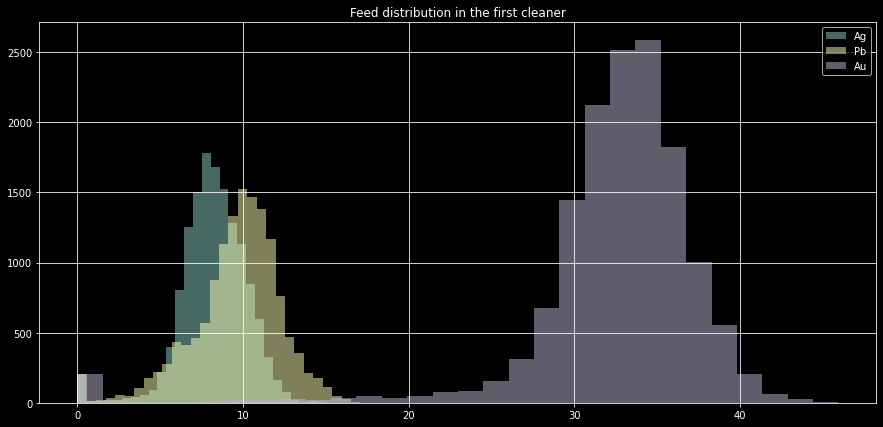

In [21]:
#сравним что получилось после первого этапа чистки по металлам 
train_df['primary_cleaner.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the first cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

Видно, что на этом этапе очень сильно удается выделить из входящей массы серебро

### secondary cleaner

In [22]:
l_cols['secondary_cleaner']

{'input': [],
 'output': ['secondary_cleaner.output.tail_ag',
  'secondary_cleaner.output.tail_pb',
  'secondary_cleaner.output.tail_sol',
  'secondary_cleaner.output.tail_au']}

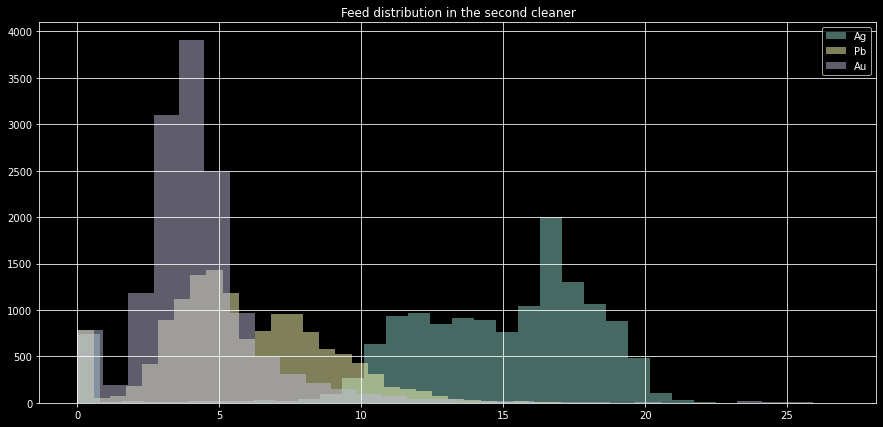

In [23]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['secondary_cleaner.output.tail_ag'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_pb'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the second cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на вторичном этапе очистки довольно большой % серебра уходит в остатки, меньше всего в остатки уходит золото

### final

In [24]:
l_cols['final']

{'input': [],
 'output': ['final.output.concentrate_ag',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.concentrate_au',
  'final.output.recovery',
  'final.output.tail_ag',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'final.output.tail_au']}

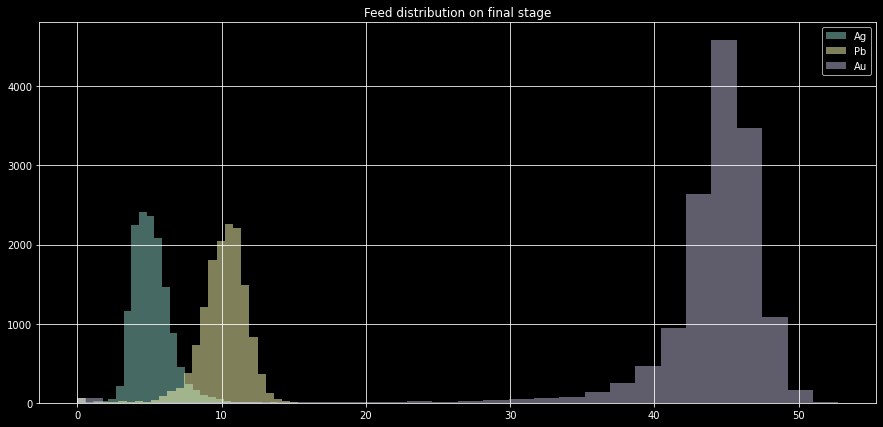

In [25]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['final.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution on final stage')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на финальном этапе вообще красота, % золота очень сильно подросла и колеблется в основном от 40% до 50%. 

будем считать, что система очистки справляется со своей работой 

## 2.2 Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.  Если распределения сильно отличаются друг от друга, оценка модели будет  неправильной

In [26]:
#посмотрим какие колонки у нас есть в тестовой 
[col for col in test_df.columns if col.split('.')[-1]=='feed_size']

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [27]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1]=='feed_size']

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

сравнить мы можем две одинаковые стадии между собой: отдельно rougher и первичный клинер

60.11051805066844 -- средний размер гранул в трейн выборке
55.951097447596965 -- средний размер гранул в тест выборке
55.37388507888542 -- медиана гранул в трейн выборке
50.841029192879 -- медиана размер гранул в тест выборке


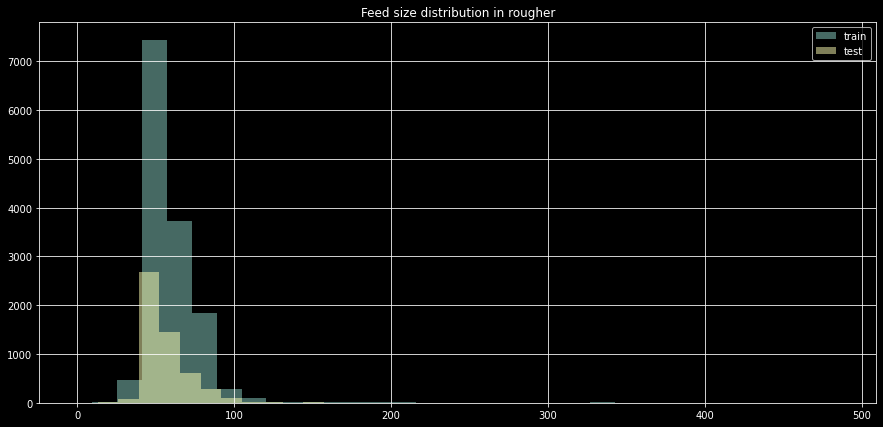

In [28]:
#сравним что получилось после второго этапа чистки по металлам 

print(train_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')

train_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
test_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

из-за выбросов в feed_size в трейн выборке не очень приятно сравнивать распределения, посмотрим без них

58.71075089900921 -- средний размер гранул в трейн выборке
55.388305241565845 -- средний размер гранул в тест выборке
55.26017512380482 -- медиана гранул в трейн выборке
50.75667403647809 -- медиана размер гранул в тест выборке


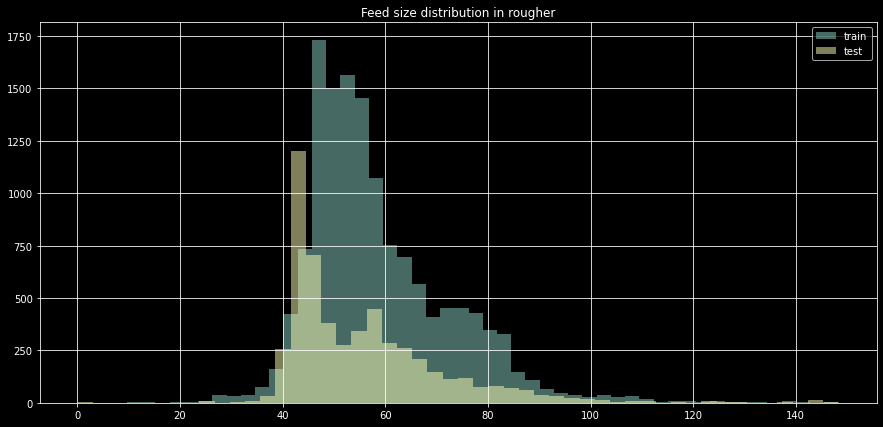

In [29]:
#сравним что получилось после второго этапа чистки по металлам, немного призумимся
print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')


train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

Распределение отличаюются, но все же скорее похожи друг на друга (оба смещены скорее влево). При этом надо отметить, что периодически залетают булыжники в массу сырья

## 2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях:  в сырье, в черновом и финальном концентратах

In [30]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1].split('_')[0]=='concentrate']

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

### rougher

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,total_conc
0,11.500771,7.101074,28.029297,19.793808,66.424950
1,11.615865,7.278807,28.067063,20.050975,67.012710
2,11.695753,7.216833,27.454037,19.737170,66.103793
3,11.915047,7.175616,27.341277,19.320810,65.752751
4,12.411054,7.240205,27.041023,19.216101,65.908382


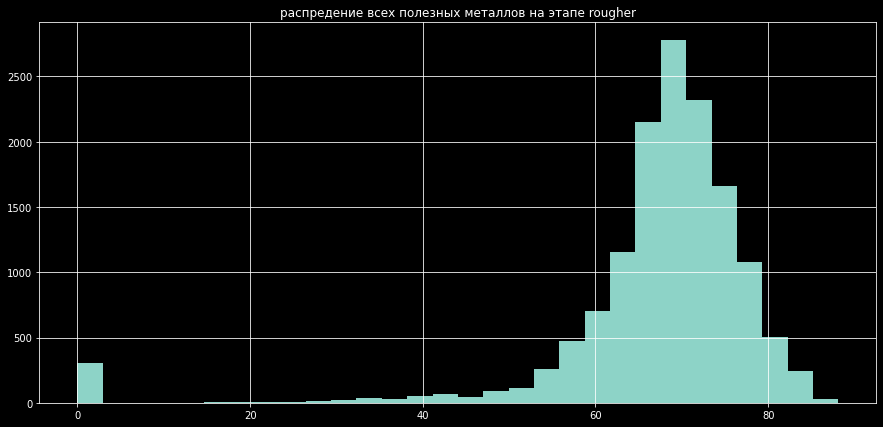

In [31]:
rougher_conc_df = train_df[['rougher.output.concentrate_ag',
                            'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol',
                            'rougher.output.concentrate_au']].copy()

rougher_conc_df['total_conc'] = rougher_conc_df.sum(axis=1)
display(rougher_conc_df.head())

rougher_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе rougher')
plt.show()

### primary_cleaner

,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,total_conc
0,8.547551,10.389648,19.529297,34.174427,72.640924
1,8.558743,10.497069,19.369147,34.118526,72.543485
2,8.603505,10.354494,19.167579,33.969464,72.095042
3,7.221879,8.496563,15.978538,28.260743,59.957723
4,9.089428,9.986786,19.199864,33.044932,71.321010


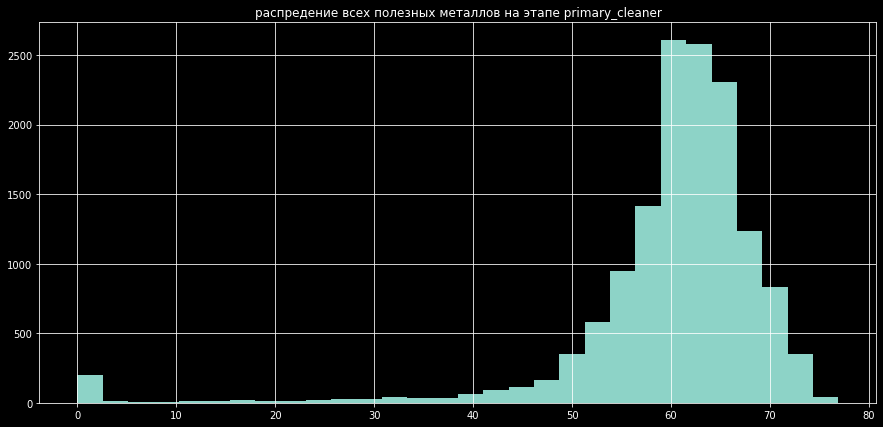

In [32]:
primary_cleaner_conc_df = train_df[['primary_cleaner.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.concentrate_au']].copy()

primary_cleaner_conc_df['total_conc'] = primary_cleaner_conc_df.sum(axis=1)
display(primary_cleaner_conc_df.head())

primary_cleaner_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе primary_cleaner')
plt.show()

### secondary cleaner

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,total_conc
0,6.055403,9.889648,5.507324,42.192020,63.644396
1,6.029369,9.968944,5.257781,42.701629,63.957723
2,6.055926,10.213995,5.383759,42.657501,64.311180
3,6.047977,9.977019,4.858634,42.689819,63.573449
4,6.148599,10.142511,4.939416,42.774141,64.004667


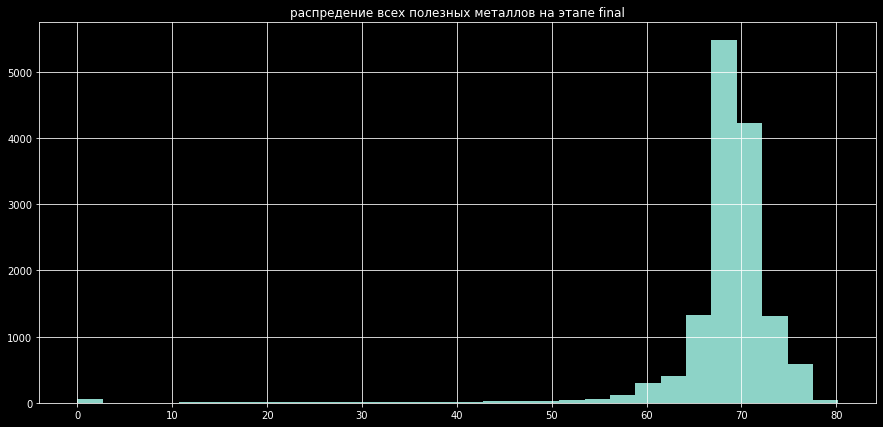

In [33]:
final_conc_df = train_df[['final.output.concentrate_ag',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
                            'final.output.concentrate_au']].copy()

final_conc_df['total_conc'] = final_conc_df.sum(axis=1)
display(final_conc_df.head())

final_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе final')
plt.show()

### total

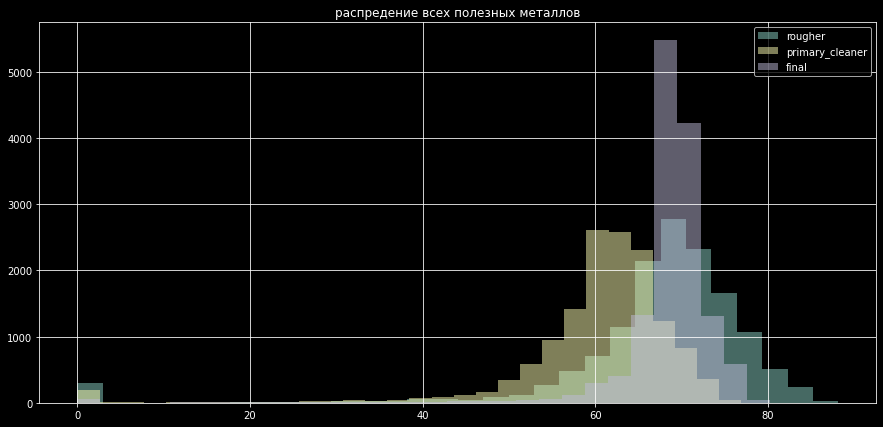

In [34]:
rougher_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
primary_cleaner_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
final_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

# Modeling 

## 3.1 Напишите функцию для вычисления итоговой sMAPE

In [35]:
def smape(target, pred): 
    smape = np.mean(abs(target-pred)/((abs(target)+abs(pred))/2)*100)
    return smape
      
scorer = make_scorer(smape)

#почистим выбросы 
def df_clean(df_reg, features, target):
    for col in df_reg[features].columns:
        lower = np.percentile(df_reg[col], 2)
        upper = np.percentile(df_reg[col], 98)        
        df_reg = df_reg[(df_reg[col]> lower) & (df_reg[col]<upper)]
        return df_reg[features], df_reg[target]

### rougher 

#### df prep

In [36]:
rougher_cols = l_cols['rougher']['input']
rougher_cols

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

тк модель должна давать прогноз сразу после стадии грубой очистки, логично предположить, что данные будут известны только по инпуту этого этапа

In [37]:
target_rougher = ['rougher.output.recovery']

In [38]:
rougher_cols = rougher_cols + target_rougher

In [39]:
rougher_train_df = train_df[rougher_cols]

In [40]:
display(rougher_train_df.isnull().sum().sort_values(ascending=False))

rougher.input.floatbank11_xanthate    428
rougher.input.feed_size               144
rougher.input.feed_pb                 100
rougher.input.feed_sol                 78
rougher.input.floatbank11_sulfate      36
rougher.input.floatbank10_sulfate      29
rougher.input.feed_rate                 8
rougher.input.floatbank10_xanthate      8
rougher.input.feed_ag                   0
rougher.input.feed_au                   0
rougher.output.recovery                 0
dtype: int64

не так уж много пропусков, проще их будет удалить 

In [41]:
print(rougher_train_df.shape)
print(rougher_train_df.dropna().shape)
rougher_train_df.dropna(inplace=True)

(14149, 11)
(13401, 11)


/var/folders/jy/3_5sjgr138bcfkgnl82l_rvr0000gn/T/ipykernel_26572/1421671327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rougher_train_df.dropna(inplace=True)


In [42]:
rougher_train_df

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,87.107763
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,86.843261
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,86.842308
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,87.226430
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,86.688794
...,...,...,...,...,...,...,...,...,...,...,...
14144,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,89.574376
14145,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,7.095508,9.297924,87.724007
14146,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,6.584130,9.300133,88.890579
14147,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,6.209517,9.297194,89.858126


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


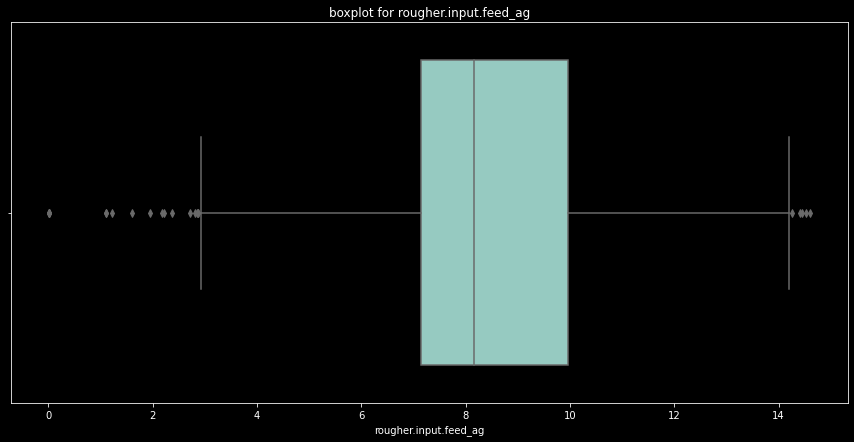

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


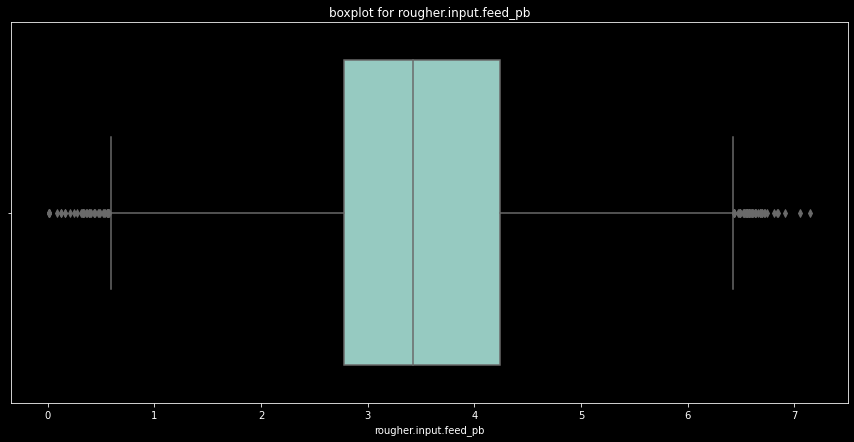

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


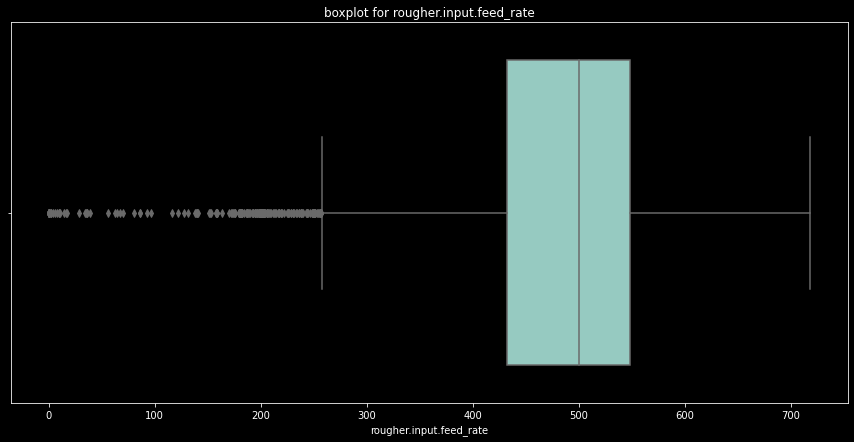

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


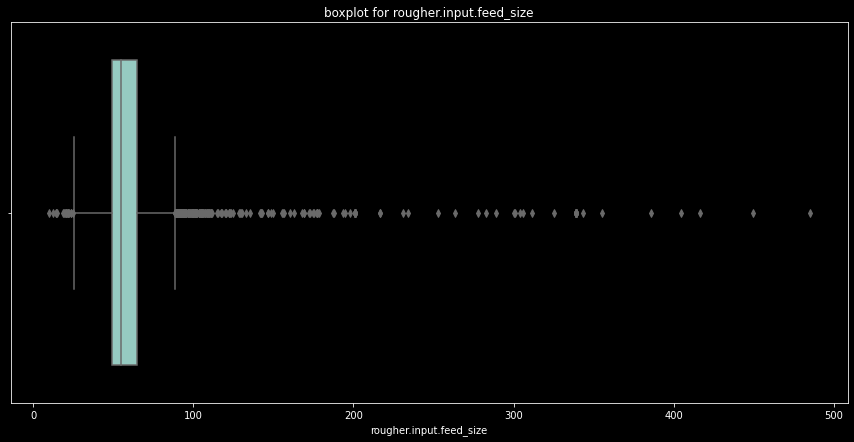

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


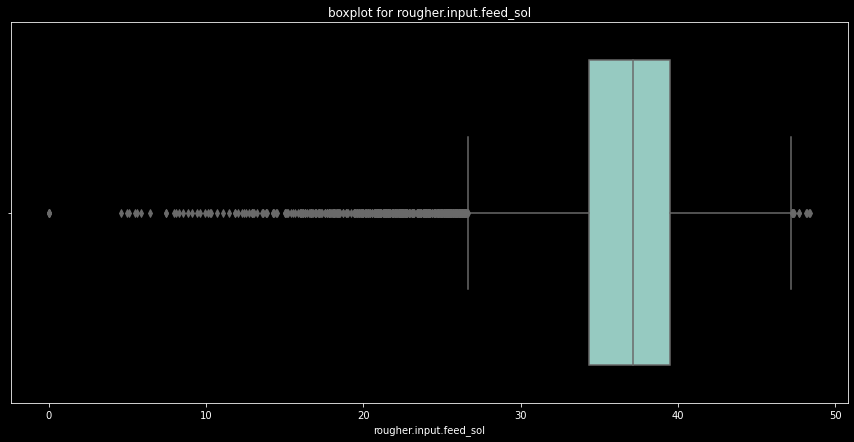

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


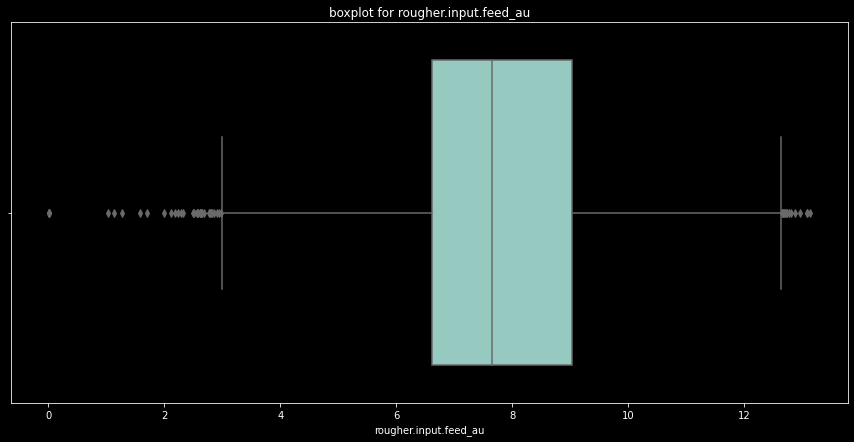

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


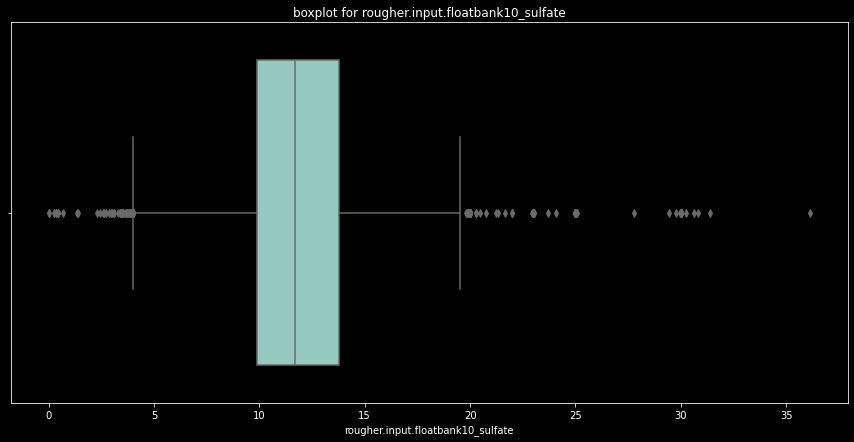

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


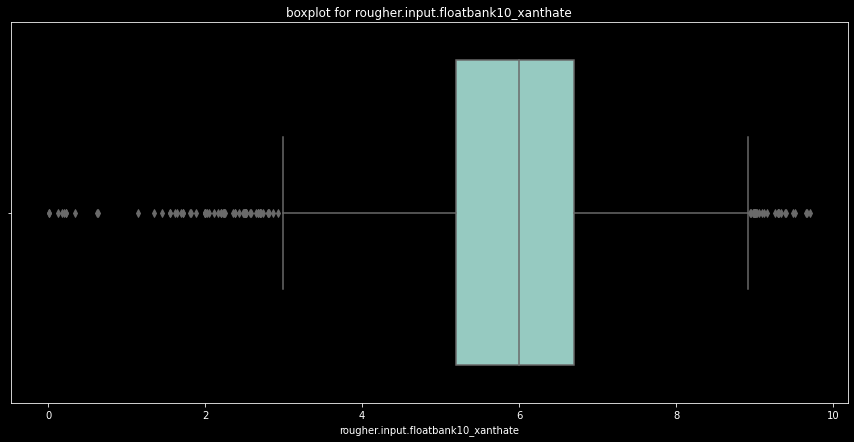

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


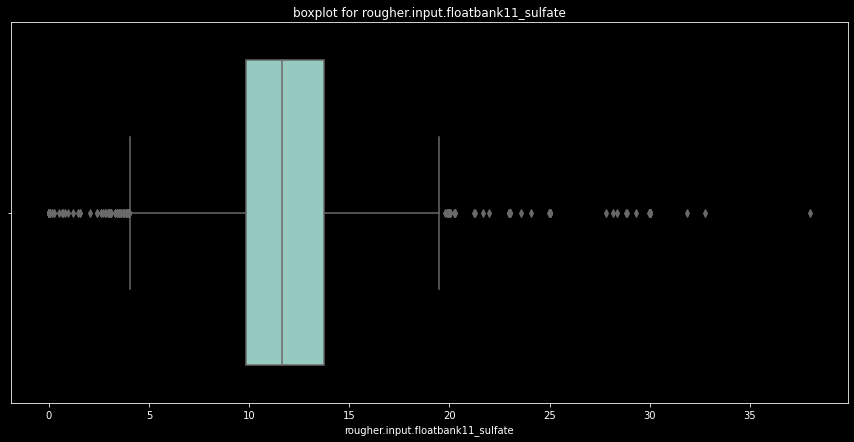

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


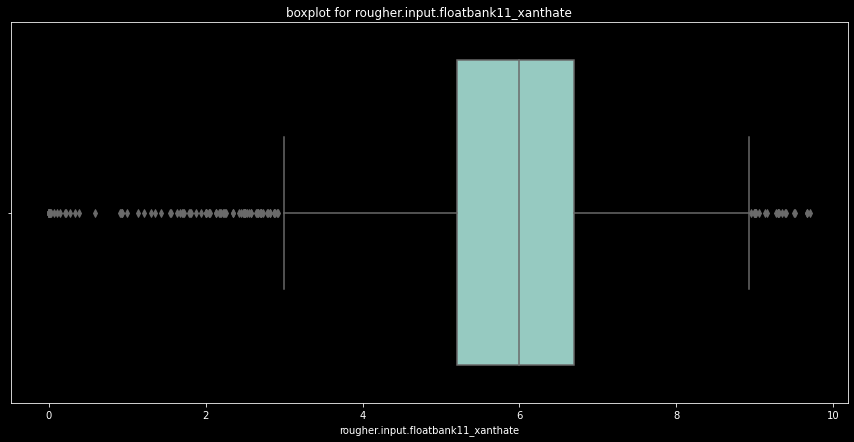

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


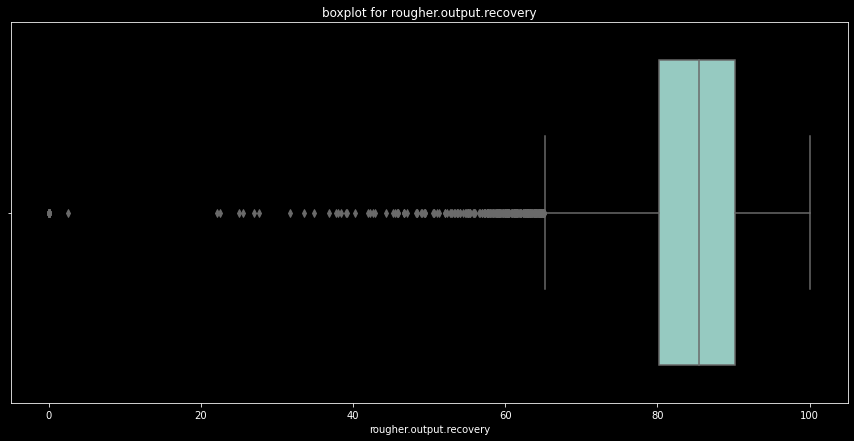

In [43]:
for col in rougher_train_df.columns:
    sns.boxplot(rougher_train_df[col])
    plt.title('boxplot for '+col)
    plt.show()

выбросов получается довольно много, чтобы назвать их аномалией, поэтому лучше убрать совсем по чуть-чуть с краев, чтоб захватить совсем уж странные объекты. остальное оставить. 

In [44]:
rougher_train_df.columns[:-1]

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate'],
      dtype='object')

In [45]:
#
x, y = df_clean(rougher_train_df, rougher_train_df.columns[:-1], 'rougher.output.recovery')

#### LR

In [46]:
#обычная линейная модель 
lr = LinearRegression()
scores = cross_val_score(lr, x, y, scoring=scorer, cv=5)
print(np.mean(scores), 'средний скор на кросс валидации для линейной модели для первого таргета') 
print(scores)
lr.fit(x,y)

10.498943867476166 средний скор на кросс валидации для линейной модели для первого таргета
[ 8.99353844  7.50393197 12.94572346 15.94283825  7.10868721]


LinearRegression()

#### rfr

In [47]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [x for x in range(3,15,3)],
    'n_estimators': [x for x in range(10,90,20)]
}


In [48]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 10, scoring=scorer)
grid_search.fit(x, y)
print(grid_search.best_params_)
best_model_rf_rougher = grid_search.best_estimator_
best_model_rf_rougher.fit(x,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 5/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 1/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 3/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 2/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 4/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 3/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 2/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 1/5; 1/16] END max_depth=3, n_estimators=10;, score=9.770 total time=   0.5s
[CV 4/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 5/5; 1/16] END max_depth=3, n_estimators=10;, score=9.527 total time=   0.5s
[CV 3/5; 1/16] END max_depth=3, n_estimators=10;

RandomForestRegressor(max_depth=12, n_estimators=10)

In [49]:
print(grid_search.best_score_)


12.765292955014186


#### catboost

In [50]:
ctb_rougher = catboost.CatBoostRegressor(verbose=100)

scores = cross_val_score(ctb_rougher, x, y, scoring=scorer, cv=5)

print(np.mean(scores), 'средний скор на кросс валидации для катбуста для первого таргета') 
print(scores)
ctb_rougher.fit(x,y)

Learning rate set to 0.059175
0:	learn: 14.1044992	total: 55.8ms	remaining: 55.8s
100:	learn: 10.2102679	total: 242ms	remaining: 2.16s
200:	learn: 9.2961913	total: 418ms	remaining: 1.66s
300:	learn: 8.5967332	total: 600ms	remaining: 1.39s
400:	learn: 8.0114384	total: 778ms	remaining: 1.16s
500:	learn: 7.4592633	total: 963ms	remaining: 959ms
600:	learn: 7.0148308	total: 1.21s	remaining: 802ms
700:	learn: 6.6000213	total: 1.42s	remaining: 606ms
800:	learn: 6.2520369	total: 1.61s	remaining: 399ms
900:	learn: 5.8791572	total: 1.81s	remaining: 200ms
999:	learn: 5.5943793	total: 2.09s	remaining: 0us
Learning rate set to 0.059175
0:	learn: 14.1208655	total: 1.63ms	remaining: 1.62s
100:	learn: 10.2474347	total: 200ms	remaining: 1.78s
200:	learn: 9.3994756	total: 454ms	remaining: 1.8s
300:	learn: 8.6747536	total: 631ms	remaining: 1.47s
400:	learn: 8.0377045	total: 822ms	remaining: 1.23s
500:	learn: 7.4621070	total: 1.1s	remaining: 1.1s
600:	learn: 7.0126854	total: 1.33s	remaining: 883ms
700:	le

##### лучшая модель rougher

лучше всего себя показала линейная регрессия на этом этапе со средним показателем скора 10,4. 

### final

In [51]:
#избавимся от ненужных колонок 
target = train_df['final.output.recovery']
train_df = train_df.drop(l_cols['final']['output'] + ['date', 'recovery_test'], axis = 1)

In [52]:
train_df = train_df[test_df.drop(['date'], axis = 1).columns].join(target)

In [53]:
train_df

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.79

In [54]:
train_df = train_df.dropna()
x, y = df_clean(train_df, train_df.drop(['final.output.recovery'], axis=1).columns, 
                                         'final.output.recovery')

#### lr2

In [55]:
lr_2 = LinearRegression()
scores = cross_val_score(lr_2, x,y, scoring=scorer)
print(scores.mean())
lr_2.fit(x,y)

10.46083018253937


LinearRegression()

#### rfr2

In [56]:
rfr2 = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rfr2, param_grid = param_grid,  
                          cv = 5, n_jobs = -1, verbose = 50, scoring=scorer)

grid_search.fit(x, y)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_model_rfr2 = grid_search.best_estimator_
best_model_rfr2.fit(x,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 2/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 1/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 3/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 4/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 5/5; 1/16] START max_depth=3, n_estimators=10...............................
[CV 1/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 2/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 3/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 5/5; 1/16] END max_depth=3, n_estimators=10;, score=10.734 total time=   1.1s
[CV 4/5; 2/16] START max_depth=3, n_estimators=30...............................
[CV 1/5; 1/16] END max_depth=3, n_estimators=10;, score=9.226 total time=   1.3s
[CV 4/5; 1/16] END max_depth=3, n_estimators=10

RandomForestRegressor(max_depth=12, n_estimators=10)

In [57]:
print(grid_search.best_score_)

10.833917730767787


#### ctb_2

In [58]:
ctb_2 = catboost.CatBoostRegressor(verbose=100)

scores = cross_val_score(ctb_2, x, y, scoring=scorer, cv=5)

print(np.mean(scores), 'средний скор на кросс валидации для катбуста для первого таргета') 
print(scores)
ctb_2.fit(x,y)


Learning rate set to 0.05866
0:	learn: 8.6471916	total: 4.87ms	remaining: 4.87s
100:	learn: 6.0447991	total: 440ms	remaining: 3.91s
200:	learn: 5.4357768	total: 812ms	remaining: 3.23s
300:	learn: 4.9283303	total: 1.46s	remaining: 3.39s
400:	learn: 4.5717982	total: 2.03s	remaining: 3.03s
500:	learn: 4.2728166	total: 2.39s	remaining: 2.38s
600:	learn: 4.0060491	total: 3s	remaining: 1.99s
700:	learn: 3.7704140	total: 3.34s	remaining: 1.43s
800:	learn: 3.5649305	total: 3.81s	remaining: 947ms
900:	learn: 3.3843599	total: 4.18s	remaining: 459ms
999:	learn: 3.2232671	total: 4.56s	remaining: 0us
Learning rate set to 0.058661
0:	learn: 8.7674328	total: 4.62ms	remaining: 4.62s
100:	learn: 6.2216004	total: 424ms	remaining: 3.77s
200:	learn: 5.6169716	total: 870ms	remaining: 3.46s
300:	learn: 5.0945309	total: 1.36s	remaining: 3.17s
400:	learn: 4.7192168	total: 1.74s	remaining: 2.6s
500:	learn: 4.4000995	total: 2.1s	remaining: 2.09s
600:	learn: 4.1212704	total: 2.45s	remaining: 1.63s
700:	learn: 3.

##### выводы по моделям final 

здесь примерно похожие результаты, линейная регрессия и случайный лес показали примерно одинаковые результаты, а вот кэтбуст выглядит сильно лучше. для второго этапа лучше брать его

### test

In [59]:
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']],
                        how='left', on = 'date').drop(['date'], axis = 1).dropna()
target_rougher_test = test_df['rougher.output.recovery']
target_final_test = test_df['final.output.recovery']


In [60]:
x_final = test_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
x_rougher = test_df[rougher_cols].drop(['rougher.output.recovery'], axis = 1)

In [61]:
test_df

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.74672

In [62]:
pred = lr.predict(x_rougher)

smape_rougher = smape(target_rougher_test, pred)

In [63]:
pred = ctb_2.predict(x_final)

smape_final = smape(target_final_test, pred)

In [64]:
print('rougher model score on test sample', smape_rougher)
print('final smape on test sample', smape_final)

rougher model score on test sample 9.000079481157748
final smape on test sample 9.021072546595304


In [65]:
smape_total = 0.25*smape_rougher+ 0.75*smape_final
print('итоговая метрика', smape_total)

итоговая метрика 9.015824280235915


# выводы 

данные не очень хорошего качества и организации: есть пропуски, из-за особенностей датасета для первой стадии есть много лишних полей. 

сам процесс работает неплохо, доля ценных металлов после этапов сильно растет. 

так же в данных довольно много выбросов, но не совсем ясна их природа, может это не аномалия, а просто булыжник завалился в руде. руды без булыжников не бывает, поэтому особо их удалять не имеет смысла -- они всегда будут

местами у данных есть ощутимый разлет в размерности, но со скалированием особого прироста не было, поэтому оставил как есть. 

лучшая модели для первого этапа --  линейная регрессия, для второго -- катбуст. 

итоговая smape получилась в районе 9%. 

